# Predicting Product Categories from Text Product Reviews

### Summary

It is possible to predict the style of a beverage from the free form reviews left by users.  Using word embedding and a random forest classifier we can achieve 94% accuracy in predicting one of four categorical labels.

The reviews have been cleaned of un-neccessary characters and tokenized.  These tokens were then passed to the word embedding algorithm Word2Vec.  The resulting output vectors can then be used to train a machine learning model to predict various labels.  In this example we will predict the style of a beer indicated in the dataset.

Import the neccessary libraries and our previously trained Word2Vec model.

In [2]:
import pyodbc
import re
import pickle

from gensim.models import Word2Vec
model = Word2Vec.load('BA_Clean_Reviews.bin')

Our dataset resides in a SQL Server database, which we can query directly using T-SQL.

In [27]:
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER=localhost;DATABASE=BA;Trusted_Connection=yes')
cursor = cnxn.cursor()

sql_stmt = '''SELECT TOP 100 style, C.comment_clean
FROM beers B
LEFT JOIN reviews R ON B.beer_id = R.beer_id
LEFT JOIN reviews_clean C ON R.SID = C.review_SID
WHERE C.comment_clean IS NOT NULL
AND style IN ('German Pilsner', 'American Stout', 'American Pale Ale (APA)', 'Belgian Saison')
ORDER BY NEWID() ASC'''

cursor.execute(sql_stmt)

rows = cursor.fetchall()

cursor.close()
del cursor

Each row returned will have a beer style and a cleaned review.  This review will be tokenized and the resulting array will be passed to our trained Word2Vec model.  The model will then return an array of vectors, with each element corresponding to the vector for a single word.  To obtain a vector that represents the entire review we will take the mean vector for every word vector in a review.

**Note**: Taking the mean vector will result in information being lost but it has still been shown to be an effective method of obtaining a document-scoped vector.

In [31]:
rows[0]

('American Pale Ale (APA)', 'from growler to belgian snifter just for fun appearance purely opaque peach with nice though brief slab of milky froth above aroma piney citric hops grapefruit orange peel pineapple but soft and loveable taste mouthfeel juicy bitter blast on the palate hoppy ride in the mouth then faintly diminishing in fervor sliding off happily urging me to take another trip to the lips ah there it is again very nice good and hoppy great tasting medium bodied long spicy hoppy fruity finish am excellent epa oddly haven marvelled over it as much on tap at the pub or on cask right now out of this brown jug it quite fine not stingy in the hop department delight for the lips and tongue and all the way down ')

In [28]:
# vectors will be our final data structure, where each element corresponds to a document-scoped vector
vectors = []
# y_clean will correspond to the style label which we will ultimately make predictions for
y_clean = []

# for each row
for i in range(0,len(rows)):
    # tokenize
    document = rows[i].comment_clean.split()
    style = rows[i].style
    try:
        # pass the token array to the model, average the resulting vectors, and append it to our output array
        vectors.append(model[document].mean(axis=0))
        y_clean.append(style)
    except:
        print ('error')

c:\users\james\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


We can review the total number of reviews returned by the query as well as the distribution of styles.  In this dataset we have four style labels: American Pale Ale (APA), German Pilsner, Belgian Saison, and the American Stout.

In [29]:
print(len(vectors))

100


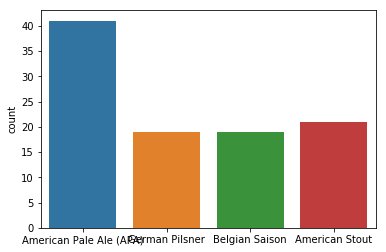

In [30]:
import seaborn as sns
sns.countplot(y_clean)

Now we will split our data into training and test datasets, fit a random forest model, and predict our style label.

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vectors, y_clean, test_size=0.20, random_state=42)

In [33]:
from sklearn.ensemble import RandomForestClassifier
RF_classifier = RandomForestClassifier(n_estimators=100, random_state=0)  
RF_classifier.fit(X_train, y_train)  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [37]:
from sklearn.metrics import accuracy_score
y_predictions = RF_classifier.predict(X_test)
print("Score:", accuracy_score(y_test, y_predictions, normalize = True))

Score: 0.55


### Conclusion

We have demonstrated how to use a Word2Vec model to obtain document embeddings. Then, how those document embeddings can be used as features for more traditional machine learning algorithms.

In our example, we acheived a 94% accuracy with no hyper-parameterzation (either in Word2Vec or the random forest) and without attempting a more thorough cleaning strategy.